# Learning model

In [1]:
from theano.sandbox import cuda
cuda.use('gpu0')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



In [3]:
%matplotlib inline
from __future__ import print_function, division
#path = "data/state/"
path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

In [4]:
batch_size=64

In [5]:
path = 'data/botles/'

## Create batches

In [7]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
test_batches = get_batches(path+'test', batch_size=batch_size, shuffle=False)

Found 2688 images belonging to 4 classes.
Found 672 images belonging to 4 classes.
Found 57 images belonging to 1 classes.


In [8]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
    test_filenames) = get_classes(path)

Found 2688 images belonging to 4 classes.
Found 672 images belonging to 4 classes.
Found 57 images belonging to 1 classes.


# Imagenet conv features

Since we have so little data, and it is similar to imagenet images (full color photos), using pre-trained VGG weights is likely to be helpful - in fact it seems likely that we won't need to fine-tune the convolutional layer weights much, if at all. So we can pre-compute the output of the last convolutional layer, as we did in lesson 3 when we experimented with dropout. (However this means that we can't use full data augmentation, since we can't pre-compute something that changes every image.)

In [6]:
vgg = Vgg16()
model=vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [7]:
conv_model = Sequential(conv_layers)

In [9]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

In [9]:
#так как мы больше не можем работать с Data augmentation мы должны перезабрать наши масивы заново
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 2688 images belonging to 4 classes.
Found 672 images belonging to 4 classes.
Found 57 images belonging to 1 classes.


In [10]:
# формируем наши фичи на основе предрасчитаного vgg imagenet
conv_feat = conv_model.predict_generator(batches, batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

In [15]:
#проверим что это выход нашей сети предрасчитанной. Кол во фичей должно быть аналогично к выходу 
#последнего conv layer  у нас на summary() это convolution2d_41 (Convolution2D)=512L, 14L, 14L
conv_val_feat.shape

(170L, 512L, 14L, 14L)

# Batchnorm dense layers on pretrained conv layers

Since we've pre-computed the output of the last convolutional layer, we need to create a network that takes that as input, and predicts our 4 classes. Let's try using a simplified version of VGG's dense layers.

Looking good! Let's try pre-computing 5 epochs worth of augmented data, so we can experiment with combining dropout and augmentation on the pre-trained model

Since we've now got a dataset 6x bigger than before, we'll need to copy our labels 6 times too.

Based on some experiments the previous model works well, with bigger dense layers.

In [8]:
def get_bn_da_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4, activation='softmax')
        ]

In [9]:
p=0.8

In [10]:
bn_model = Sequential(get_bn_da_layers(p))
bn_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 40320 samples, validate on 672 samples
Epoch 1/4
40320/40320 [==============================] - 26s - loss: 0.8001 - acc: 0.7049 - val_loss: 0.4479 - val_acc: 0.8438
Epoch 2/4
40320/40320 [==============================] - 27s - loss: 0.6890 - acc: 0.7440 - val_loss: 0.4209 - val_acc: 0.8482
Epoch 3/4
40320/40320 [==============================] - 27s - loss: 0.6193 - acc: 0.7727 - val_loss: 0.3934 - val_acc: 0.8586
Epoch 4/4
40320/40320 [==============================] - 27s - loss: 0.5514 - acc: 0.7963 - val_loss: 0.3663 - val_acc: 0.8676


In [23]:
bn_model.optimizer.lr=0.001

In [27]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))
# Результат должен быть acc:0.86 на val_ac:0.79

Train on 40320 samples, validate on 672 samples
Epoch 1/4
40320/40320 [==============================] - 26s - loss: 0.3125 - acc: 0.8878 - val_loss: 0.2967 - val_acc: 0.9062
Epoch 2/4
40320/40320 [==============================] - 27s - loss: 0.3090 - acc: 0.8890 - val_loss: 0.2996 - val_acc: 0.9033
Epoch 3/4
40320/40320 [==============================] - 26s - loss: 0.2925 - acc: 0.8958 - val_loss: 0.2975 - val_acc: 0.9018
Epoch 4/4
40320/40320 [==============================] - 26s - loss: 0.2923 - acc: 0.8978 - val_loss: 0.3008 - val_acc: 0.9033


In [29]:
bn_model.optimizer.lr=0.00001

In [30]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=256, 
             validation_data=(conv_val_feat, val_labels))
# Результат должен быть acc:0.89 на val_ac:0.81

Train on 40320 samples, validate on 672 samples
Epoch 1/256
40320/40320 [==============================] - 26s - loss: 0.2895 - acc: 0.8982 - val_loss: 0.2963 - val_acc: 0.9033
Epoch 2/256
40320/40320 [==============================] - 25s - loss: 0.2816 - acc: 0.9005 - val_loss: 0.2937 - val_acc: 0.9033
Epoch 3/256
40320/40320 [==============================] - 26s - loss: 0.2762 - acc: 0.9028 - val_loss: 0.2973 - val_acc: 0.9003
Epoch 4/256
40320/40320 [==============================] - 25s - loss: 0.2718 - acc: 0.9048 - val_loss: 0.2895 - val_acc: 0.9048
Epoch 5/256
40320/40320 [==============================] - 26s - loss: 0.2628 - acc: 0.9069 - val_loss: 0.2906 - val_acc: 0.9092
Epoch 6/256
40320/40320 [==============================] - 27s - loss: 0.2650 - acc: 0.9070 - val_loss: 0.2983 - val_acc: 0.9033
Epoch 7/256
40320/40320 [==============================] - 25s - loss: 0.2679 - acc: 0.9052 - val_loss: 0.2976 - val_acc: 0.9033
Epoch 8/256
40320/40320 [========================

Looks good - let's save those weights.

In [38]:
bn_model.save_weights(path+'results/da_conv8_1_3.h5')

In [20]:
bn_model.load_weights(path+'results/da_conv8_1_3.h5')

In [40]:
bn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_6 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 25088)         0           maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 25088)         0           flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 256)           6422784     dropout_3[0][0]                  
___________________________________________________________________________________________

# Submit

We'll find a good clipping amount using the validation set, prior to submitting.

In [21]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)

In [22]:
keras.metrics.categorical_crossentropy(val_labels, do_clip(val_preds, 0.93)).eval()

NameError: name 'val_labels' is not defined

In [23]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [24]:
preds = bn_model.predict(conv_test_feat, batch_size=batch_size*2)

In [25]:
subm = do_clip(preds,0.93)

In [26]:
subm_name = path+'results/subm.gz'

In [50]:
classes = sorted(batches.class_indices, key=batches.class_indices.get)

In [53]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])
submission#.head(10)

,img,1,2,3,4
0,0.jpg,0.930000,0.010243,0.007778,0.007778
1,0jpg.jpg,0.930000,0.007778,0.007778,0.007778
2,1.jpg,0.007778,0.930000,0.007778,0.007778
3,10.jpg,0.007778,0.007778,0.007778,0.930000
4,11.jpg,0.930000,0.007778,0.007778,0.007778
5,12.jpg,0.930000,0.007778,0.009513,0.007778
6,13.jpg,0.030927,0.032437,0.930000,0.007778
7,14.jpg,0.015829,0.930000,0.007778,0.007778
8,15.jpg,0.084884,0.911997,0.007778,0.007778
9,16.jpg,0.544594,0.007778,0.444635,0.007778


In [29]:
conv_test_feat.shape

(57L, 512L, 14L, 14L)

Receivig full model where productivity would be same:

In [57]:
final_model = Sequential(conv_layers)
bn_layers = bn_model.layers #get_bn_da_layers(p)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: 
    final_model.add(layer)
    

In [58]:
final_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [59]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[9][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[9][0]            
___________________________________________________________________________________________

[[  2.7304e-04   5.4656e-04   8.3965e-04   9.9834e-01]]
Class is [3]


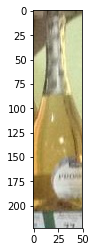

In [63]:
from skimage.io import imread
import cv2


#original=imread("vodka.jpg")#sham1#cog#vodka
#s = cv2.resize(original, (224, 224))
#sm=s.transpose(2, 0, 1)

original=imread(path+'test/100/39.jpg')#sham1#cog#vodka

s = cv2.resize(original, (224, 224))
s=s.transpose(2, 0, 1)
a=s.reshape((1, s.shape[0], s.shape[1], s.shape[2]))

prediction = final_model.predict(a)
print (prediction)
print("Class is {}".format(np.argmax(prediction, axis=1)))
plt.imshow(original, interpolation='none')

In [65]:
final_model.save_weights(path+'results/final_20170101.h5')